In [1]:
import os, sys, time, datetime, random

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
# conda install pytorch torchvision -c pytorch

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import cv2
# conda install -c conda-forge opencv


In [2]:
videopath = '../data/robot_parcours_1.avi'

In [111]:
# Create an vector of frames with values from 0 to 1 and invert colors
from skimage.color import rgb2gray


cap = cv2.VideoCapture(videopath)
frames = []

while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        break
    
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = img/255. # values from 0 to 1 and negative
    img = rgb2gray(img)
    img = abs(img - 1.) # invert colors

    frames.append(img)
    
    if cv2.waitKey(1) == ord('q'):
        break
        
cap.release()

In [112]:
shape_frame = frames[0].shape
n_frames = len(frames)

print(shape_frame)
print(n_frames)

(480, 720)
42


In [113]:
shape_number = (28,28)

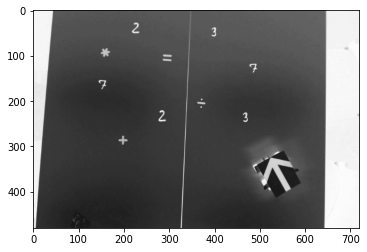

In [115]:
plt.imshow(frames[0], cmap='gray')

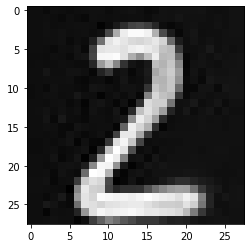

In [117]:
plt.imshow(frames[0][218:246,270:298], cmap='gray')

In [118]:
print((480-28)*(720-28))

312784


In [120]:
# Create height * width image windows

windows = []
for frame in frames:
    sliding_w = []
    for j in range(shape_frame[0] - shape_number[0]):
        for i in range(shape_frame[1] - shape_number[1]):
            sliding_w.append(frame[j:j+shape_number[0],i:i+shape_number[1]])
    windows.append(sliding_w)

In [121]:
print(windows[0][0].shape)

(28, 28)


In [122]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [12]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [32]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size) 
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

In [24]:
# Invert colors

# train_images = abs(train_images - 255)
# test_images = abs(test_images - 255)

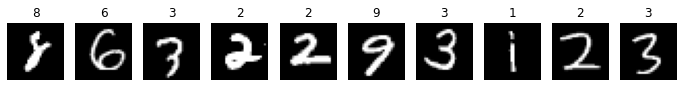

In [33]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

In [34]:
train_img = train_images / 255.
test_img = test_images / 255.

In [35]:
flat_train_img = train_img.reshape(train_img.shape[0],-1)
flat_test_img = test_img.reshape(test_img.shape[0],-1)

In [36]:
def to_one_hot(x, nb_classes):
    output = np.zeros((x.shape[0], nb_classes))
    for i in range(x.shape[0]):
        output[i,x[i]] = 1.
    return output

train_labels_hot = to_one_hot(train_labels, 10)
test_labels_hot = to_one_hot(test_labels, 10)

In [37]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='adam', alpha=1e-5,
                    hidden_layer_sizes=(100,), activation = 'relu', random_state=1, max_iter = 500)

mlp.fit(flat_train_img, train_labels_hot)

print("Training set loss: %f" % mlp.loss_)
print("Training set score: %f" % mlp.score(flat_train_img, train_labels_hot))
print("Test set score : %f" % mlp.score(flat_test_img, test_labels_hot))     

Training set loss: 0.000939
Training set score: 1.000000
Test set score : 0.956400


In [145]:
mlp.predict_proba(doss_flat)

array([[1.72548739e-062, 3.60510957e-055, 3.34545930e-033,
        2.78976444e-009, 1.97712986e-114, 8.22704251e-034,
        3.23730965e-048, 3.43569055e-051, 1.00991808e-027,
        4.23573023e-051],
       [1.46895846e-057, 1.39471798e-056, 1.23494499e-033,
        9.52601410e-013, 1.63877224e-112, 4.49464678e-036,
        3.41039190e-049, 2.03414329e-048, 1.47258718e-024,
        6.41866179e-062],
       [4.95418552e-057, 7.28294304e-059, 4.89180876e-033,
        1.10343728e-013, 1.69281607e-107, 2.41696434e-034,
        3.83204917e-051, 1.77225015e-047, 6.91900377e-025,
        5.40909849e-066],
       [6.37728486e-056, 3.84415812e-060, 4.27856688e-034,
        2.41109618e-015, 6.46086154e-103, 9.77349201e-029,
        2.42100483e-049, 3.69784775e-053, 2.10268520e-028,
        1.20184476e-060],
       [1.91413592e-056, 5.81464466e-060, 3.82757625e-039,
        3.04626325e-019, 1.63914279e-096, 2.20635394e-023,
        3.27022044e-048, 1.12184235e-049, 3.31420167e-033,
        1.4

In [140]:
mlp.predict(train_images[plt_ind].reshape(train_images[plt_ind].shape[0],-1))


array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

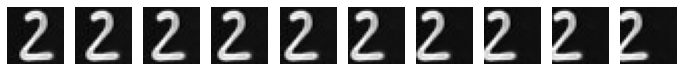

In [128]:
x = 151818
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im in zip(axes, doss):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    

In [134]:
doss = np.array(windows[0][x:x+10])
doss_flat = doss.reshape(doss.shape[0],-1)
print(doss.shape)
print(doss_flat.shape)

(10, 28, 28)
(10, 784)


In [123]:
print(flat_train_img.shape)

(60000, 784)
